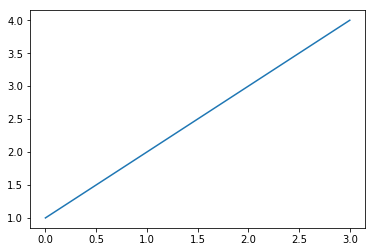

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot([1,2,3,4])


cnn: Model saved in file: ./model/cnnmodel.ckpt
0.8818181818181818
cnn: Model saved in file: ./model/cnnmodel.ckpt
0.8454545454545455


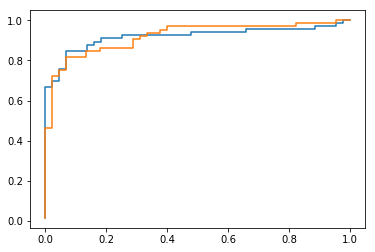

In [18]:
# %load cnn.py
import dataLoader as loader
import numpy as np
import tensorflow as tf
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

consts = {
    'modelPath' : './model/cnnmodel.ckpt',
    'maxepoch' : 25,
}

def weight_varible(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def avg_pool_3x3(x):
    return tf.nn.avg_pool(x, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='SAME')

def model(x,keep_prob):
    W_conv1 = weight_varible([5, 5, 1, 5])
    b_conv1 = bias_variable([5])

    # conv layer-1
    x_image = tf.reshape(x, [-1, 24, 24, 1])

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = avg_pool_2x2(h_conv1)

    # conv layer-2
    W_conv2 = weight_varible([5, 5, 5, 15])
    b_conv2 = bias_variable([15])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = avg_pool_3x3(h_conv2)

    # full connection
    W_fc1 = weight_varible([60, 30])
    b_fc1 = bias_variable([30])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 60])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # dropout
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # output layer:
    W_fc2 = weight_varible([30, 2])
    b_fc2 = bias_variable([2])

    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    return y_conv

'''
input train data:
{
    vin1:{
        'feature':[[mat1],[mat2],...]
        'label': [0,1] or [1,0]
    },
    vin2:{},..
}

'''
def train(train):
    #model construction
    num_of_epoch=consts['maxepoch']
    #data = loader.matrix_loader(trainVin,testVin)
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, [None, 576])
    y_ = tf.placeholder(tf.float32, [None, 2])

    keep_prob = tf.placeholder(tf.float32)
    y_conv = model(x,keep_prob)

    # model training
    cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.arg_max(y_conv, 1), tf.arg_max(y_, 1))

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(init)
        #training procedure
        for i in range(num_of_epoch):
            trset = train
            #batch size = 1
            for each in trset.keys():
                dat = trset[each]
                train_data = dat['feature']
                label_data = np.array(dat['label']).reshape(1,2)
                for d in train_data:
                    d = np.array(d).reshape(1,576)
                    train_step.run(feed_dict = {x: d, y_: label_data, keep_prob: 0.5})
        save_path = saver.save(sess, consts['modelPath'])
        print ("cnn: Model saved in file: " + save_path)
    return 1

'''
input test data:
{
    vin:{
        'feature':[[mat1],[mat2],..]
        'label':[[0,1]] -- visit: label[0][0/1]
    }
}

output details:
{
    vin:{
        'feature':[[mat1],[mat2],...]
        'label':[[0,1]]
        'preddetail':[[pred1],[pred2],...]
        'predsum':[p(y=0|x),p(y=1|x)]
        'predres': True/False
        'prediction': 0/1
    }
}
'''
def classify(test):
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, [None, 576])

    keep_prob = tf.placeholder(tf.float32)
    y_conv = model(x,keep_prob)

    y_predicted = tf.reduce_mean(y_conv,0)

    with tf.Session() as sess:
        # Restore variables from disk.
        saver = tf.train.Saver()
        saver.restore(sess, consts['modelPath'])
        # test of each vin
        correct = 0
        for each in test.keys():
            dat = test[each]
            feat = dat['feature']
            label = dat['label']
            pred = []
            l = len(feat)
            for d in feat:
                testData = np.asarray(d).reshape(1,576)
                predicted = y_predicted.eval(feed_dict = {x:testData, keep_prob: 0.5})
                pred.append(predicted)
            predicted = np.sum(pred,axis = 0)/float(l)
            test[each]['preddetail']=pred
            test[each]['predsum'] = predicted
            test[each]['predres'] = False
            test[each]['prediction'] = 1-np.argmax(label)
            if(np.argmax(predicted)==np.argmax(label)):
                correct+=1
                test[each]['predres'] = True
                test[each]['prediction'] = np.argmax(label)

        acc = float(correct)/float(len(test.keys()))
        return {'detail':test,'accuracy':acc}


data = loader.mapFile()
plt.figure()
th = []
tstacc=[]
kf=KFold(n=len(data.keys()),n_folds=2,shuffle=True)
for tr,tst in kf:
    trk = np.asarray(list(data.keys()))[tr]
    tstk = np.asarray(list(data.keys()))[tst]
    train_data = dict((k,v) for k,v in data.items() if k in trk)
    test_data = dict((k,v) for k,v in data.items() if k in tstk)
    train(train_data)
    p = classify(test_data)
    problist = []
    labellist = []
    for each in p['detail'].keys():
        dat = p['detail'][each]
        probability = dat['predsum'][1]
        label = dat['label'][0][1]
        problist.append(probability)
        labellist.append(label)
    fpr, tpr, thresholds = roc_curve(labellist, problist)
    a = auc(fpr,tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % a)
    metrics = np.asarray(1-fpr+tpr)
    threshold = np.asarray(thresholds)
    optimal_threashold = np.sum(metrics*threshold)/np.sum(metrics)
    th.append(optimal_threashold)
    print(p['accuracy'])
    tstacc.append(p['accuracy'])